# Data science experiments on credit cards dataset

This notebook attempts to simulate the model training code a data scientist may provide as input to the ML architecture.

First, import libraries and load the data.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Path to the raw training data
_data_root = '../data'
_data_filename = "dataset.csv"
_data_filepath = os.path.join(_data_root, _data_filename)
dataframe = pd.read_csv(_data_filepath)
dataframe.head()

,Unnamed: 0,Age,Annual_Income,Credit_Score,Loan_Amount,Loan_Duration_Years,Number_of_Open_Accounts,Had_Past_Default,Loan_Approval
0,0,35.0,107770.0,331.0,31580.0,28,13.0,0,0
1,1,52.0,NaN,636.0,9012.0,5,14.0,0,1
2,2,56.0,160017.0,809.0,45310.0,19,13.0,1,1
3,3,52.0,41654.0,422.0,47966.0,17,7.0,1,0
4,4,30.0,73198.0,414.0,35636.0,2,3.0,1,1


Print dataset info and description using `pandas`.

In [2]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               1000 non-null   int64  
 1   Age                      950 non-null    float64
 2   Annual_Income            970 non-null    float64
 3   Credit_Score             960 non-null    float64
 4   Loan_Amount              980 non-null    float64
 5   Loan_Duration_Years      1000 non-null   int64  
 6   Number_of_Open_Accounts  990 non-null    float64
 7   Had_Past_Default         1000 non-null   int64  
 8   Loan_Approval            1000 non-null   int64  
dtypes: float64(5), int64(4)
memory usage: 70.4 KB


In [3]:
dataframe.describe()

,Unnamed: 0,Age,Annual_Income,Credit_Score,Loan_Amount,Loan_Duration_Years,Number_of_Open_Accounts,Had_Past_Default,Loan_Approval
count,1000.000000,950.000000,970.000000,960.000000,980.000000,1000.000000,990.000000,1000.00000,1000.000000
mean,499.500000,44.357895,113529.173196,574.825000,28061.729592,14.832000,7.348485,0.51000,0.514000
std,288.819436,15.268179,49879.543788,154.573626,12962.369681,8.424057,3.967101,0.50015,0.500054
min,0.000000,18.000000,30060.000000,301.000000,5006.000000,1.000000,1.000000,0.00000,0.000000
25%,249.750000,31.000000,67129.750000,442.000000,17662.250000,8.000000,4.000000,0.00000,0.000000
50%,499.500000,45.000000,113365.500000,574.500000,28201.500000,15.000000,7.000000,1.00000,1.000000
75%,749.250000,58.000000,159608.000000,707.000000,38693.750000,22.000000,11.000000,1.00000,1.000000
max,999.000000,69.000000,199991.000000,849.000000,49989.000000,29.000000,14.000000,1.00000,1.000000


Plot class balance.

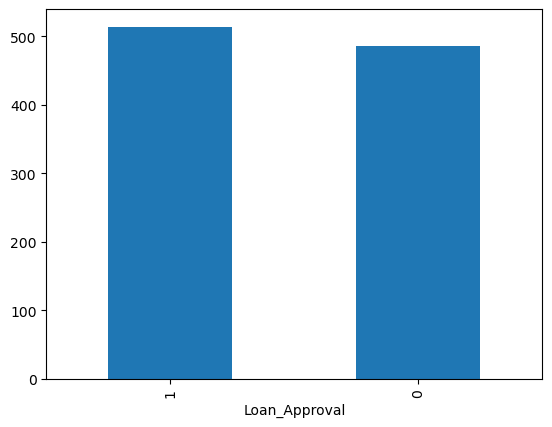

In [4]:
dataframe['Loan_Approval'].value_counts().plot(kind='bar');

Most of the columns have missing values, which will have to be handled in the data preprocessing. The unnamed column contains observation indexes and can be dropped. All of the other columns appear to contain useful information. The only categorical column is *Had_Past_Default*, which is already encoded as 0s and 1s, so no additional processing is needed. Finally, the classes appear to be well balanced so balancing techniques will probably not be needed.

In [5]:
dataframe.drop(columns=["Unnamed: 0"], inplace=True)
dataframe.fillna(0, inplace=True)
dataframe.describe()

,Age,Annual_Income,Credit_Score,Loan_Amount,Loan_Duration_Years,Number_of_Open_Accounts,Had_Past_Default,Loan_Approval
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.00000,1000.000000
mean,42.140000,110123.298000,551.83200,27500.495000,14.832000,7.27500,0.51000,0.514000
std,17.748392,52808.112624,188.77845,13420.465049,8.424057,4.01441,0.50015,0.500054
min,0.000000,0.000000,0.00000,0.000000,1.000000,0.00000,0.00000,0.000000
25%,29.000000,65156.750000,425.75000,17015.500000,8.000000,4.00000,0.00000,0.000000
50%,44.000000,110510.000000,567.50000,27702.000000,15.000000,7.00000,1.00000,1.000000
75%,57.000000,158513.750000,699.00000,38485.750000,22.000000,11.00000,1.00000,1.000000
max,69.000000,199991.000000,849.00000,49989.000000,29.000000,14.00000,1.00000,1.000000


The preprocessed dataset is split (80% train, 20% test).

In [6]:
target_variable = "Loan_Approval"
X_train, X_test, y_train, y_test = train_test_split(dataframe.drop(columns=[target_variable]), dataframe[target_variable], test_size=0.2, shuffle=True, random_state=1337)
X_train.shape

(800, 7)

A simple hyperparameter search is run over a gradient boosting classifier.

In [7]:
categorical_feature = "Had_Past_Default"
numerical_features = [category for category in X_train.columns if category != categorical_feature]
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', StandardScaler(), numerical_features),
        ('categorical', 'passthrough', [categorical_feature])
    ])
classifier = GradientBoostingClassifier()
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', classifier)])

param_distributions = {
    'classifier__learning_rate': np.logspace(-3, 0, num=20),
    'classifier__n_estimators': np.linspace(50, 300, num=20, dtype=int),
    'classifier__max_depth': np.linspace(3, 10, num=20, dtype=int),
}
search = RandomizedSearchCV(pipeline, param_distributions, n_iter=40, cv=5, verbose=0, random_state=1337, n_jobs=-1)
search.fit(X_train, y_train)

best_params = search.best_params_
print(f"Best parameters: {best_params}")
print(f"Best score: {search.best_score_}")

Best parameters: {'classifier__n_estimators': np.int64(168), 'classifier__max_depth': np.int64(6), 'classifier__learning_rate': np.float64(0.001)}
Best score: 0.5349999999999999


The final model is trained with the hyperparameters and tested.

In [8]:
pipeline.set_params(**best_params)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.18      0.25       102
           1       0.47      0.78      0.59        98

    accuracy                           0.47       200
   macro avg       0.46      0.48      0.42       200
weighted avg       0.46      0.47      0.42       200



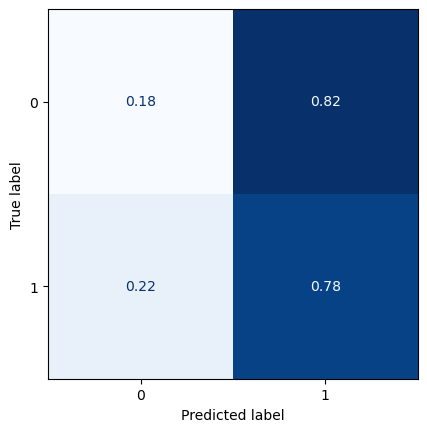

In [9]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', cmap='Blues', colorbar=False);

With the model trained, we can also run various interpretability tests in case we wish to change the training procedure.

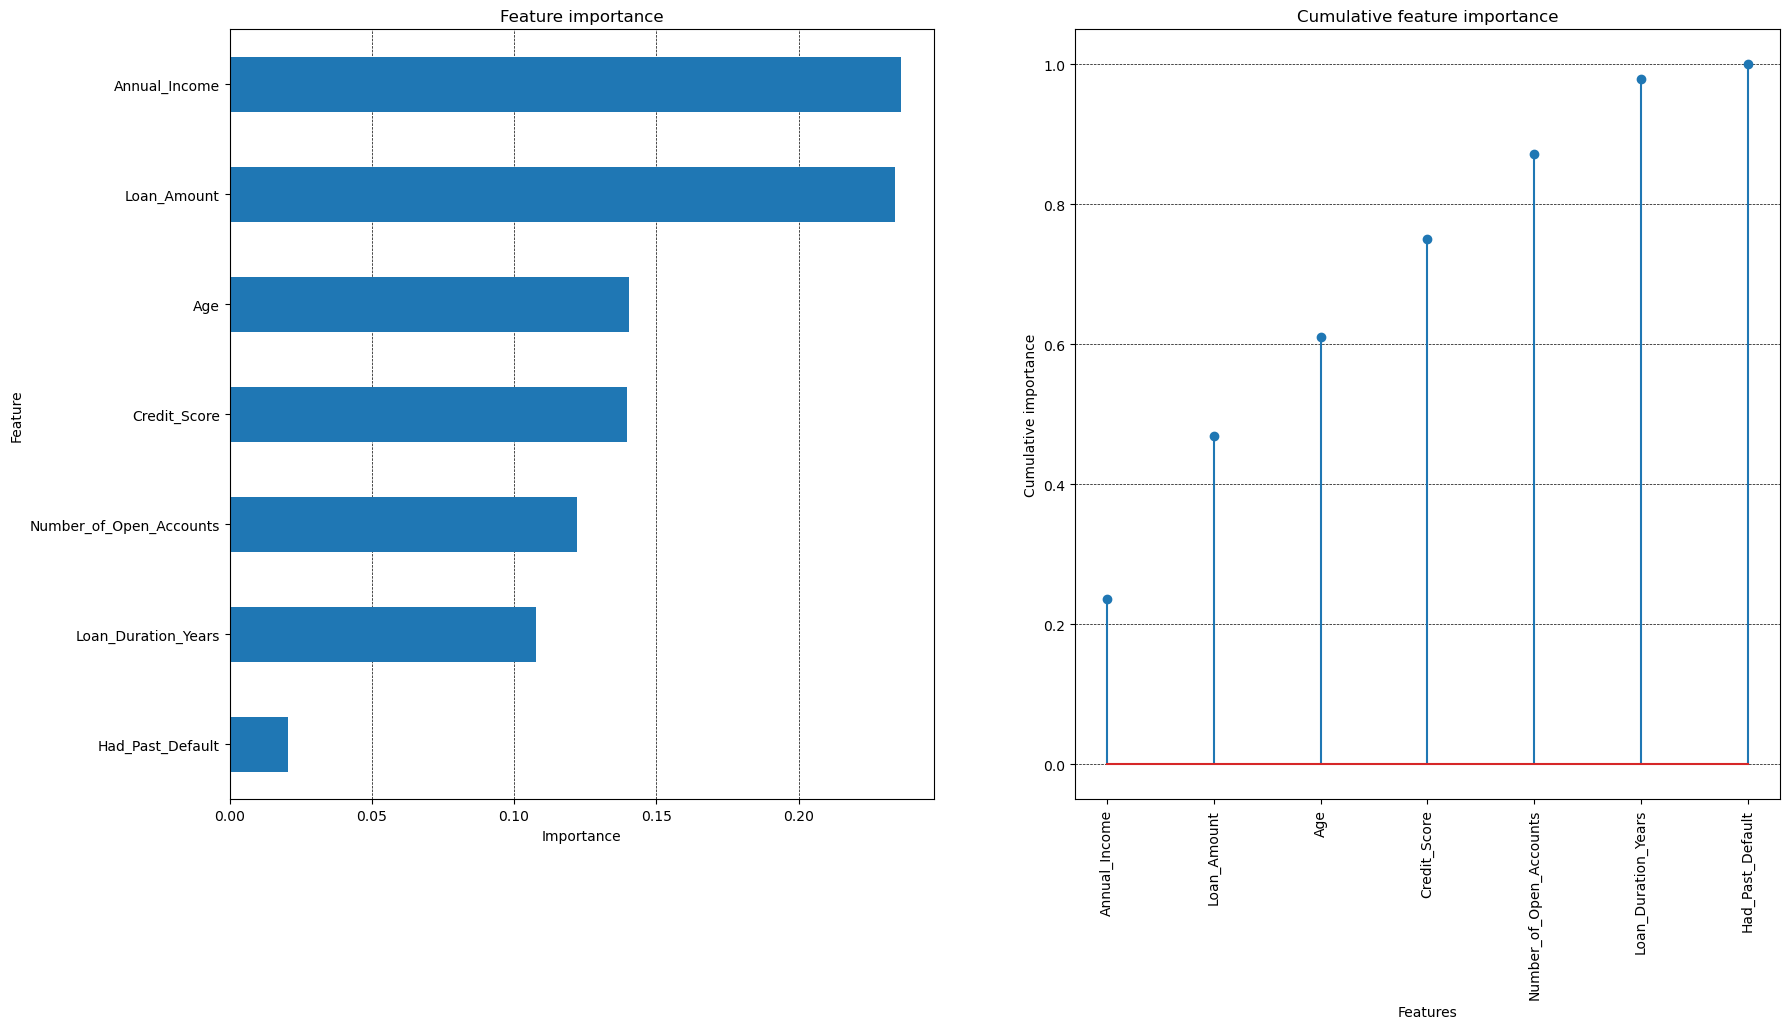

In [10]:
best_features = pipeline.named_steps['classifier'].feature_importances_
best_features = pd.Series(best_features, index=X_train.columns)
best_features /= best_features.sum()
best_features_cumulative = best_features.sort_values(ascending=False).cumsum()
best_features.sort_values(inplace=True)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

best_features.plot(kind="barh", ax=ax[0])
ax[0].set_title("Feature importance")
ax[0].grid(axis="x", which="both", color="black", linestyle="--", linewidth=0.5)
ax[0].set_axisbelow(True)
ax[0].set_xlabel("Importance")
ax[0].set_ylabel("Feature")

ax[1].stem(best_features_cumulative.index, best_features_cumulative)
ax[1].set_title("Cumulative feature importance")
ax[1].grid(axis="y", which="both", color="black", linestyle="--", linewidth=0.5)
ax[1].set_axisbelow(True)
ax[1].set_xlabel("Features")
ax[1].set_ylabel("Cumulative importance")
ax[1].set_xticks(
    rotation="vertical",
    ticks=range(len(best_features_cumulative)),
    labels=best_features_cumulative.index,
)
plt.show()

## Extra: Using MLflow

Optionally, if you are using the JupyterLab interface included in the architecture ([localhost:8085](http://localhost:8085)), you can register the model above with mlflow experiments and runs, as presented bellow.

In [ ]:
import mlflow

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "http://minio:8081"
os.environ["AWS_ACCESS_KEY_ID"] = "access2024minio"
os.environ["AWS_SECRET_ACCESS_KEY"] = "supersecretaccess2024"
mlflow.set_tracking_uri("http://mlflow:8083")
mlflow.set_experiment("mlflow_tracking_model")
mlflow.sklearn.autolog(
    log_model_signatures=True,
    log_input_examples=True,
    registered_model_name="clients_model",
)

with mlflow.start_run(run_name="autolog_pipe_model_reg") as run:
    pipeline.fit(X_train, y_train)
    # ...
    # mlflow.sklearn.log_model...
    # mlflow.log_metric...